# Google Play Store App Installs Prediction
Dataset: [https://www.kaggle.com/datasets/lava18/google-play-store-apps]

### Objective
Predict App installs based on rating, category, genres, etc...

### Dataset
The dataset includes data of 10841 app on google play and 13 columns describing the data

In [47]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import os 

import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
sns.set(rc={'figure.figsize':(25,15)})

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import plotly.figure_factory as ff

import warnings
warnings.filterwarnings('ignore')


In [48]:
df = pd.read_csv('googleplaystore.csv')
df = df.rename(columns={'Size': 'App_Size'})
df

,App,Category,Rating,Reviews,App_Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6M,100+,Free,0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5M,"1,000+",Free,0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


## 1. Data Preprocessing

### Parse installs number to int

In [49]:
df['Installs'] = df['Installs'].apply(lambda x: x.replace(',', '').replace('+', '') )

### Parse Size to int

In [50]:
df['App_Size'] = df['App_Size'].apply(lambda x: x.replace('M', ''))

### Parse Price to int

In [51]:
df['Price'] = df['Price'].apply(lambda x: x.replace('$', ''))

### Split 'Content'

In [52]:
#df = pd.get_dummies(df, columns = ['Content Rating']) # one hot encoding
#df.head()

### Split 'Genres'

In [53]:
# Split the 'Genres' column into multiple columns with a prefix
#genres_df = df['Genres'].str.get_dummies(';')

# Concatenate the resulting DataFrame with the original DataFrame
#df = pd.concat([df, genres_df], axis=1)

# Display the resulting DataFrame
df

,App,Category,Rating,Reviews,App_Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19,10000,Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14,500000,Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25,50000000,Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53,5000,Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6,100,Free,0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5,1000,Free,0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,Varies with device,1000,Free,0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


### Change 'Last Updated' from date type to int

In [54]:
# Convert Last Updated date to monts passed since last update
def months_diff(date_str):
    # Parse the input string and convert it to a datetime object
    try:
        date = datetime.strptime(date_str, '%B %d, %Y')
    except:
        return ''

    # Calculate the difference between the input date and January 1, 2019
    diff = relativedelta(datetime(2019, 1, 1), date)

    # Return the number of months
    return diff.years * 12 + diff.months


df['Last Updated'] = df['Last Updated'].apply(lambda x: months_diff(x) )
    
df.head()

,App,Category,Rating,Reviews,App_Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19,10000,Free,0,Everyone,Art & Design,11,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14,500000,Free,0,Everyone,Art & Design;Pretend Play,11,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0,Everyone,Art & Design,5,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25,50000000,Free,0,Teen,Art & Design,6,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0,Everyone,Art & Design;Creativity,6,1.1,4.4 and up


## 2. Data Cleaning

### Check for missing values and replace them with median

In [55]:
df.isna().sum()

App                  0
Category             0
Rating            1474
Reviews              0
App_Size             0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [56]:
df["Rating"]=df["Rating"].fillna(df["Rating"].median())
df.isna().sum()

App               0
Category          0
Rating            0
Reviews           0
App_Size          0
Installs          0
Type              1
Price             0
Content Rating    1
Genres            0
Last Updated      0
Current Ver       8
Android Ver       3
dtype: int64

### Replace null data and unwanted data

In [57]:
#Checking for missing, or null, data
df.isnull().sum().sort_values(ascending = False)

Current Ver       8
Android Ver       3
Type              1
Content Rating    1
App               0
Category          0
Rating            0
Reviews           0
App_Size          0
Installs          0
Price             0
Genres            0
Last Updated      0
dtype: int64

### Find indexes where app size is in KB

In [58]:
k_indexes = []
for i in range (len(df)):
    if 'k' in df['App_Size'][i]:
        k_indexes.append(i)
print(len(k_indexes))

316


### Checking for incorrect data types in numeric columns

In [59]:
#Function to return true if string can be parsed to float
def is_float(string):
    try:
        float(string)
        return True
    except ValueError:
        return False

#Function to return index of values that are not numerical and their count
def find_incorrect_types(p):
    x = []
    for i in range (len(df)):
        if not(p[i].isdigit() or is_float(p[i])):
            x.append(i)
    return x
print(find_incorrect_types(df['Price'].values.astype(str).tolist()))
print("----------------")
print(find_incorrect_types(df['Reviews'].values.astype(str).tolist()))
print("----------------")
print(find_incorrect_types(df['Installs'].values.astype(str).tolist()))

[10472]
----------------
[10472]
----------------
[10472]


In [60]:
#Dropping row with noisy data in all columns
df = df.drop(10472)
df

,App,Category,Rating,Reviews,App_Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19,10000,Free,0,Everyone,Art & Design,11,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14,500000,Free,0,Everyone,Art & Design;Pretend Play,11,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0,Everyone,Art & Design,5,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25,50000000,Free,0,Teen,Art & Design,6,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0,Everyone,Art & Design;Creativity,6,1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53,5000,Free,0,Everyone,Education,17,1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6,100,Free,0,Everyone,Education,5,1.0,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,4.3,3,9.5,1000,Free,0,Everyone,Medical,23,1.0,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,Varies with device,1000,Free,0,Mature 17+,Books & Reference,47,Varies with device,Varies with device


### Checking for negative values in numerical attributes

In [61]:
#Parsing all numerical attribute values to int or float
df['Price'] = df['Price'].astype(str).astype(float)
df['Installs'] = df['Installs'].astype(str).astype(int)
df['Reviews'] = df['Reviews'].astype(str).astype(int)
df['Rating'] = df['Rating'].astype(str).astype(float)

#Function which returns indexes of negative numbers 
def find_negative (values):
    noise = []
    for i in range (len(df)):
        if values[i] < 0:
            noise.append(i)
    return noise

#Checking if numerical columns have any negative values
print(find_negative(df['Price'].values.tolist()))
print(find_negative(df['Reviews'].values.tolist()))
print(find_negative(df['Installs'].values.tolist()))
print(find_negative(df['Rating'].values.tolist()))

[]
[]
[]
[]


In [62]:
size_indexes = df.index[df['App_Size'] == 'Varies with device'].tolist()
print(len(size_indexes))
#App size column contains 1695 records where app size is not specified and 316 records where app size is in KB

1695


### Replacing missing app sizes with median value

In [63]:
#First replacing missing sizes and sizes in KB with 0 to be able to parse column values to int
df['App_Size'] = df['App_Size'].astype(str)
for i in size_indexes:
    df.loc[i,'App_Size'] = '0'

for i in k_indexes:
    df.loc[i,'App_Size'] = '0'

In [64]:
#Parsing App_Size values to float
df['App_Size'] = df['App_Size'].astype(float)

#Converting values in KB to MB
for i in k_indexes:
    df.loc[i, 'App_Size'] = df['App_Size'][i] / 1000
    
#Replacing missing values with median App_Size
for i in size_indexes:
    df.loc[i, 'App_Size'] = df['App_Size'].median()

In [65]:
df.drop_duplicates(subset='App', inplace=True)
df = df[df['Android Ver'] != np.nan]
df = df[df['Android Ver'] != 'NaN']
df = df[df['Installs'] != 'Free']
df = df[df['Installs'] != 'Paid']
df

,App,Category,Rating,Reviews,App_Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,11,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,11,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,5,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,Art & Design,6,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,6,1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53.0,5000,Free,0.0,Everyone,Education,17,1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6,100,Free,0.0,Everyone,Education,5,1.0,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,4.3,3,9.5,1000,Free,0.0,Everyone,Medical,23,1.0,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,9.2,1000,Free,0.0,Mature 17+,Books & Reference,47,Varies with device,Varies with device


### Remove '+' from 'Number of Installs' to make it numeric


In [66]:
df['Installs'] = df['Installs'].apply(lambda x: x.replace('+', '') if '+' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: x.replace(',', '') if ',' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: int(x))

### Convert all app sizes to MB

In [67]:
df['App_Size'] = df['App_Size'].apply(lambda x: str(x).replace('Varies with device', 'NaN') if 'Varies with device' in str(x) else x)

df['App_Size'] = df['App_Size'].apply(lambda x: str(x).replace('M', '') if 'M' in str(x) else x)
df['App_Size'] = df['App_Size'].apply(lambda x: str(x).replace(',', '') if 'M' in str(x) else x)
df['App_Size'] = df['App_Size'].apply(lambda x: float(str(x).replace('k', '')) / 1000 if 'k' in str(x) else x)


df['App_Size'] = df['App_Size'].apply(lambda x: float(x))
df['Installs'] = df['Installs'].apply(lambda x: float(x))

df['Price'] = df['Price'].apply(lambda x: str(x).replace('$', '') if '$' in str(x) else str(x))
df['Price'] = df['Price'].apply(lambda x: float(x))

df['Reviews'] = df['Reviews'].apply(lambda x: int(x))

## Exploratory Data Analysis

### Basic EDA

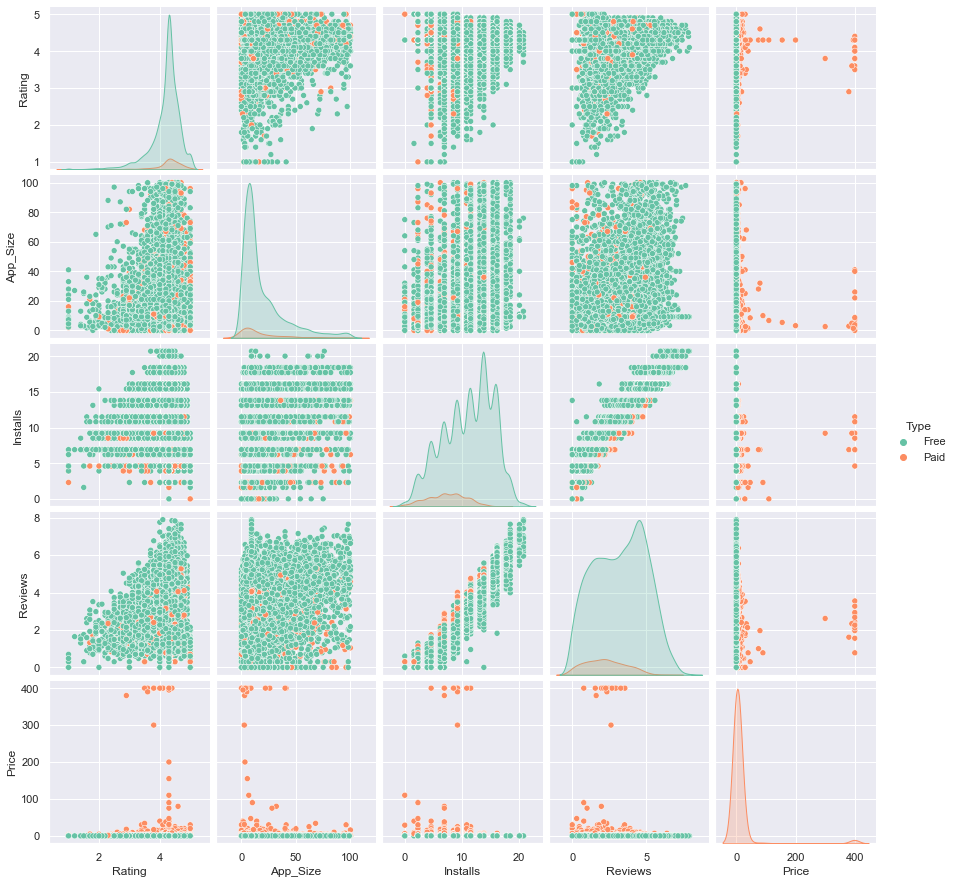

In [68]:
x = df['Rating']
y = df['App_Size']
z = df['Installs']
p = df['Reviews']
t = df['Type']
price = df['Price']

p = sns.pairplot(pd.DataFrame(list(zip(x, y, np.log(z), np.log10(p), t, price)), 
                        columns=['Rating','App_Size', 'Installs', 'Reviews', 'Type', 'Price']), hue='Type', palette="Set2")

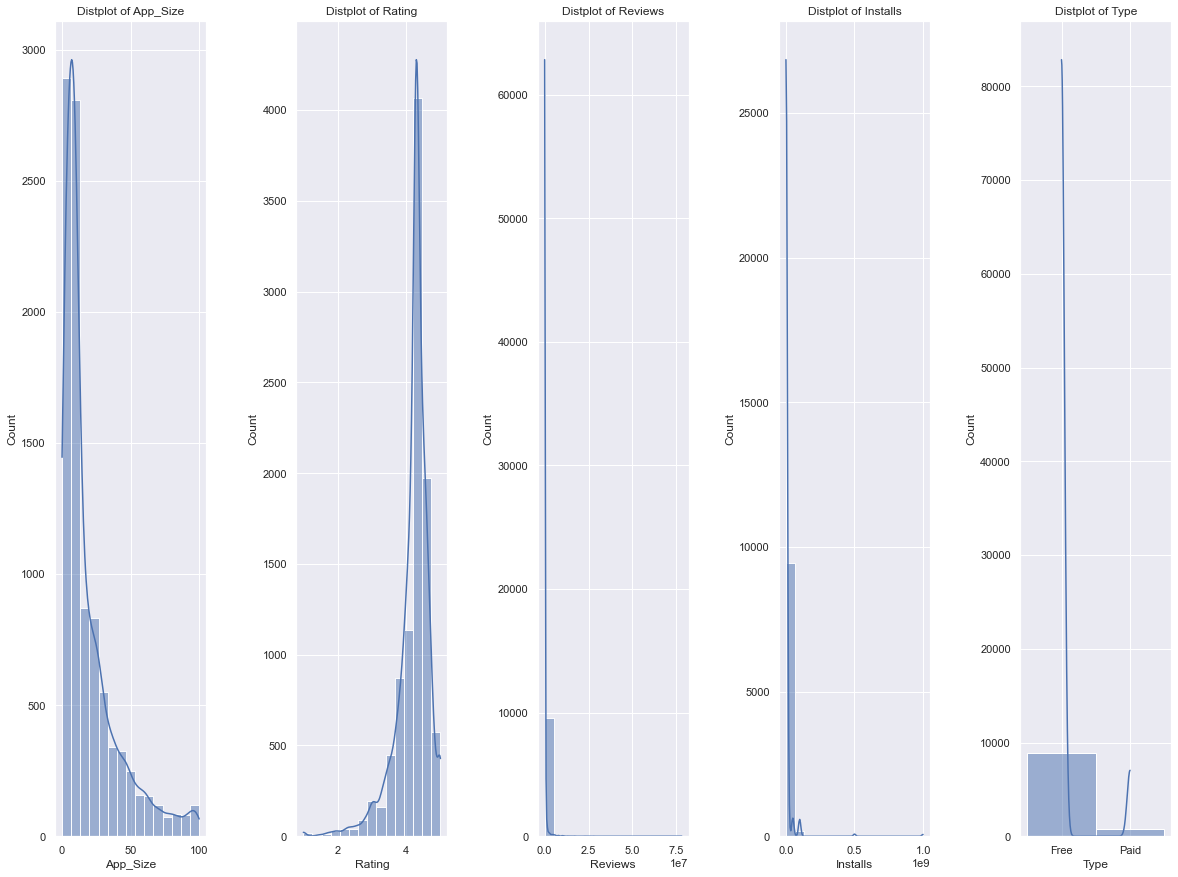

In [118]:
# importing the required modules
import matplotlib.pyplot as plt
import seaborn as sns

# graph size
plt.figure(1 , figsize = (20 , 15))
graph = 0 

# for loop
for x in ['App_Size' , 'Rating' , 'Reviews','Installs','Type']:
    graph += 1
    
    # ploting graph
    plt.subplot(1 , 5 , graph)
    plt.subplots_adjust(hspace = 0.6 , wspace = 0.6)
    sns.histplot(df[x] , bins = 15, kde=True)
    plt.title('Distplot of {}'.format(x))

# showing the graph
plt.show();

### Category breakdown

In [69]:
number_of_apps_in_category = df['Category'].value_counts().sort_values(ascending=True)

data = [go.Pie(
        labels = number_of_apps_in_category.index,
        values = number_of_apps_in_category.values,
        hoverinfo = 'label+value'
    
)]

plotly.offline.iplot(data, filename='active_category')

- **Family** and **Game** apps have the highest market prevelance. 
- Interestingly, **Tools, Business and Medical** apps are also catching up.

### Average rating of apps
looks like replacing using the median wan't the best of ideas

In [70]:
data = [go.Histogram(
        x = df.Rating,
        xbins = {'start': 1, 'size': 0.1, 'end' :5}
)]

print('Average app rating = ', np.mean(df['Rating']))
plotly.offline.iplot(data, filename='overall_rating_distribution')

Average app rating =  4.192442281809774


### App ratings across categories 

F_onewayResult(statistic=11.99865886742203, pvalue=5.743457805901705e-19)

The p-value is extremely small, hence we reject the null hypothesis in favor of the alternate hypothesis.



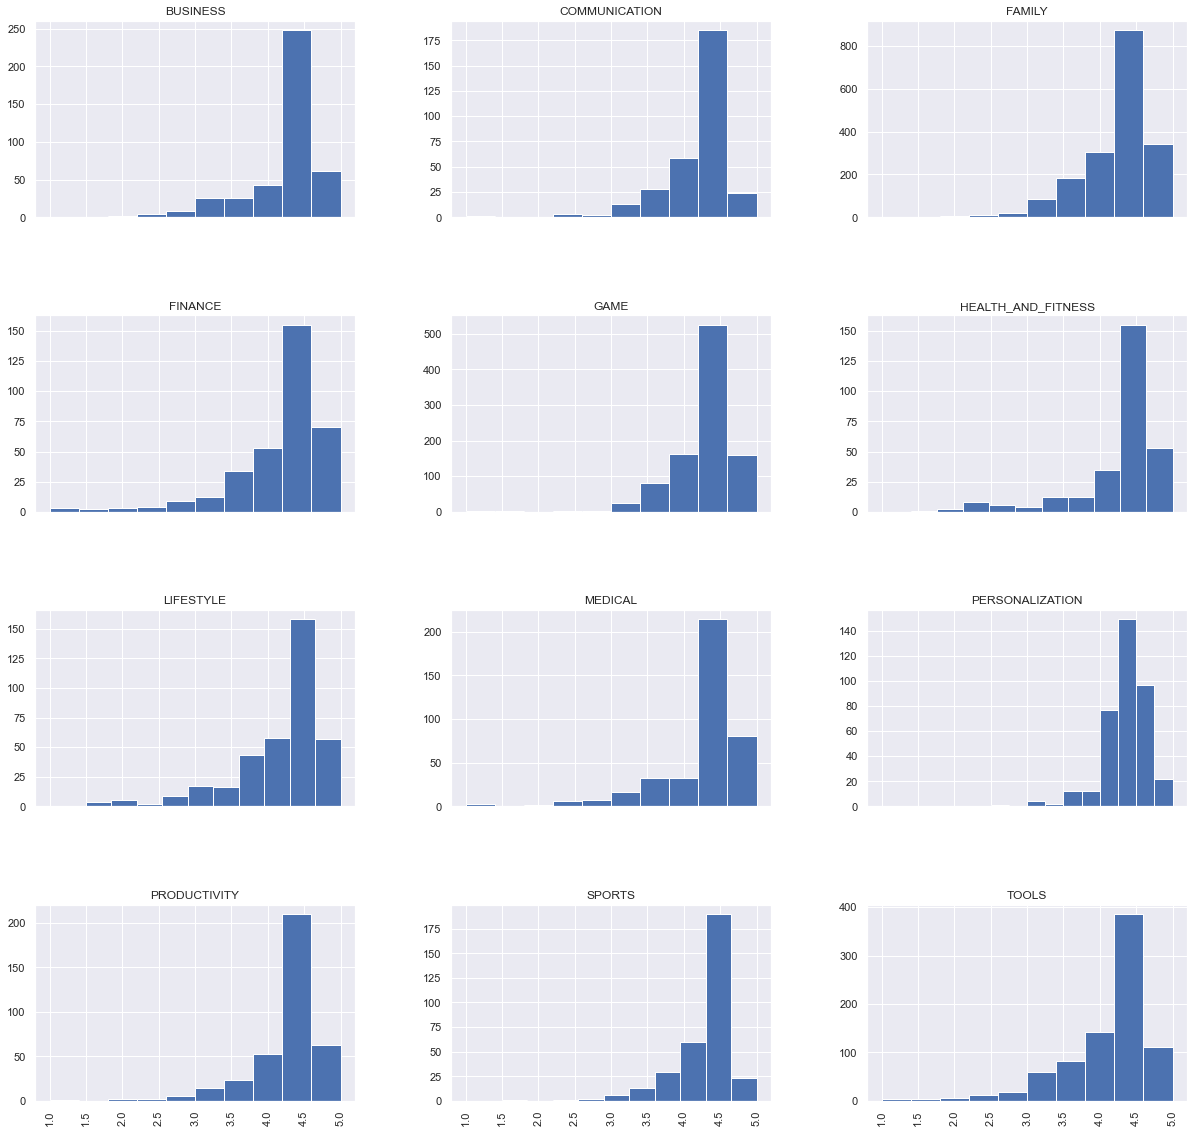

In [81]:
import scipy.stats as stats
f = stats.f_oneway(df.loc[df.Category == 'BUSINESS']['Rating'].dropna(), 
               df.loc[df.Category == 'FAMILY']['Rating'].dropna(),
               df.loc[df.Category == 'GAME']['Rating'].dropna(),
               df.loc[df.Category == 'PERSONALIZATION']['Rating'].dropna(),
               df.loc[df.Category == 'LIFESTYLE']['Rating'].dropna(),
               df.loc[df.Category == 'FINANCE']['Rating'].dropna(),
               df.loc[df.Category == 'EDUCATION']['Rating'].dropna(),
               df.loc[df.Category == 'MEDICAL']['Rating'].dropna(),
               df.loc[df.Category == 'TOOLS']['Rating'].dropna(),
               df.loc[df.Category == 'PRODUCTIVITY']['Rating'].dropna()
              )

print(f)
print('\nThe p-value is extremely small, hence we reject the null hypothesis in favor of the alternate hypothesis.\n')
#temp = df.loc[df.Category.isin(['BUSINESS', 'DATING'])]

groups = df.groupby('Category').filter(lambda x: len(x) > 286).reset_index()
array = groups['Rating'].hist(by=groups['Category'], sharex=True, figsize=(20,20))

### Best performing categories

In [82]:
groups = df.groupby('Category').filter(lambda x: len(x) >= 170).reset_index()
#print(type(groups.item.['BUSINESS']))
print('Average rating = ', np.nanmean(list(groups.Rating)))
#print(len(groups.loc[df.Category == 'DATING']))
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 720, len(set(groups.Category)))]


#df_sorted = df.groupby('Category').agg({'Rating':'median'}).reset_index().sort_values(by='Rating', ascending=False)
#print(df_sorted)

layout = {'title' : 'App ratings across major categories',
        'xaxis': {'tickangle':-40},
        'yaxis': {'title': 'Rating'},
          'plot_bgcolor': 'rgb(250,250,250)',
          'shapes': [{
              'type' :'line',
              'x0': -.5,
              'y0': np.nanmean(list(groups.Rating)),
              'x1': 19,
              'y1': np.nanmean(list(groups.Rating)),
              'line': { 'dash': 'dashdot'}
          }]
          }

data = [{
    'y': df.loc[df.Category==category]['Rating'], 
    'type':'violin',
    'name' : category,
    'showlegend':False,
    #'marker': {'color': 'Set2'},
    } for i,category in enumerate(list(set(groups.Category)))]



plotly.offline.iplot({'data': data, 'layout': layout})

Average rating =  4.190419588731724


### Size vs Rating


In [83]:
groups = df.groupby('Category').filter(lambda x: len(x) >= 50).reset_index()

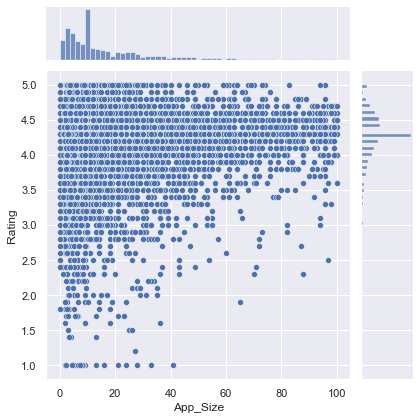

In [84]:
sns.set_style("darkgrid")
ax = sns.jointplot(df['App_Size'], df['Rating'])

### Price impact on rating


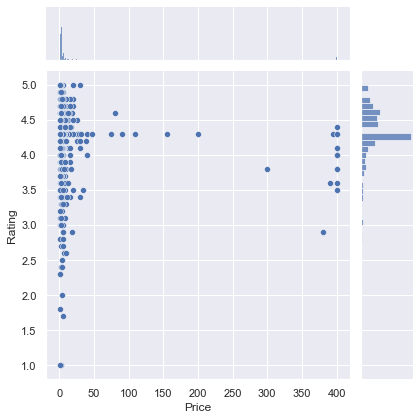

In [85]:
paid_apps = df[df.Price>0]
p = sns.jointplot( "Price", "Rating", paid_apps)


###  Price vs Category  

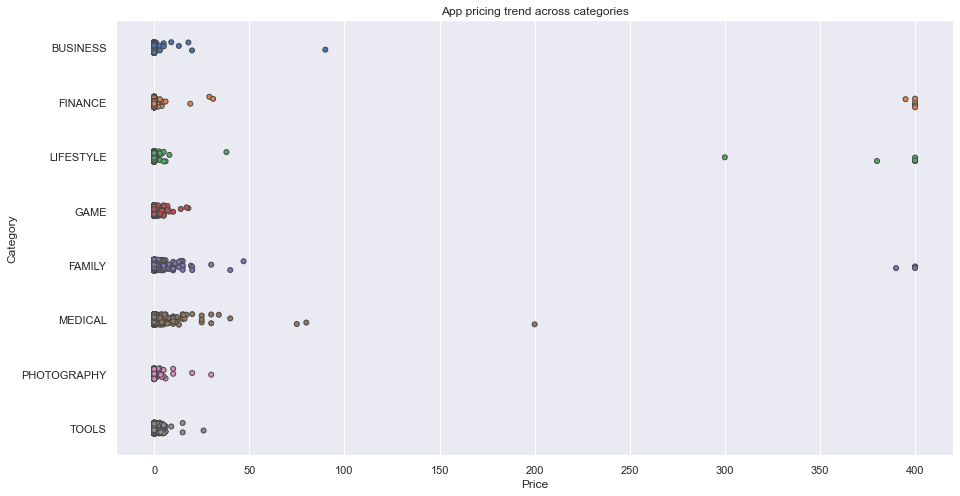

In [86]:
subset_df = df[df.Category.isin(['GAME', 'FAMILY', 'PHOTOGRAPHY', 'MEDICAL', 'TOOLS', 'FINANCE',
                                 'LIFESTYLE','BUSINESS'])]
sns.set_style('darkgrid')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
p = sns.stripplot(x="Price", y="Category", data=subset_df, jitter=True, linewidth=1)
title = ax.set_title('App pricing trend across categories')


#### Junk apps:

In [87]:
df[['Category', 'App']][df.Price > 200]

,Category,App
4197,FAMILY,most expensive app (H)
4362,LIFESTYLE,💎 I'm rich
4367,LIFESTYLE,I'm Rich - Trump Edition
5351,LIFESTYLE,I am rich
5354,FAMILY,I am Rich Plus
5355,LIFESTYLE,I am rich VIP
5356,FINANCE,I Am Rich Premium
5357,LIFESTYLE,I am extremely Rich
5358,FINANCE,I am Rich!
5359,FINANCE,I am rich(premium)


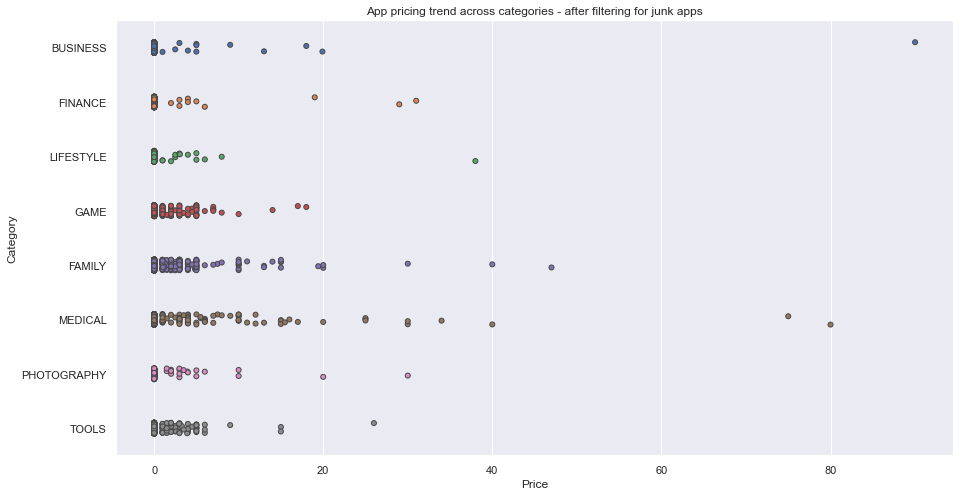

In [88]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
subset_df_price = subset_df[subset_df.Price<100]
p = sns.stripplot(x="Price", y="Category", data=subset_df_price, jitter=True, linewidth=1)
title = ax.set_title('App pricing trend across categories - after filtering for junk apps')

### Distribution of paid and free apps across categories

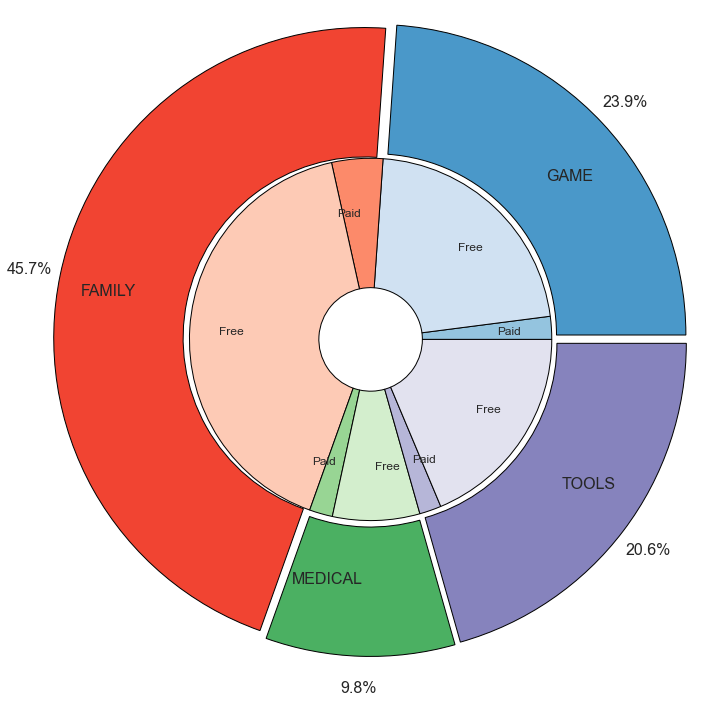

In [89]:
# Stacked bar graph for top 5-10 categories - Ratio of paid and free apps
new_df = df.groupby(['Category', 'Type']).agg({'App' : 'count'}).reset_index()

outer_group_names = ['GAME', 'FAMILY', 'MEDICAL', 'TOOLS']
outer_group_values = [len(df.App[df.Category == category]) for category in outer_group_names]

a, b, c, d=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples]


inner_group_names = ['Paid', 'Free'] * 4
inner_group_values = []


for category in outer_group_names:
    for t in ['Paid', 'Free']:
        x = new_df[new_df.Category == category]
        try:
            inner_group_values.append(int(x.App[x.Type == t].values[0]))
        except:
            inner_group_values.append(0)

explode = (0.025,0.025,0.025,0.025)
# First Ring (outside)
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('equal')
mypie, texts, _ = ax.pie(outer_group_values, radius=1.2, labels=outer_group_names, autopct='%1.1f%%', pctdistance=1.1,
                                 labeldistance= 0.75,  explode = explode, colors=[a(0.6), b(0.6), c(0.6), d(0.6)], textprops={'fontsize': 16})
plt.setp( mypie, width=0.5, edgecolor='black')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(inner_group_values, radius=1.2-0.5, labels=inner_group_names, labeldistance= 0.7, 
                   textprops={'fontsize': 12}, colors = [a(0.4), a(0.2), b(0.4), b(0.2), c(0.4), c(0.2), d(0.4), d(0.2)])
plt.setp( mypie2, width=0.5, edgecolor='black')
plt.margins(0,0)
 
# show it
plt.tight_layout()
plt.show()




### Installs of paid apps Vs free apps

In [90]:
trace0 = go.Box(
    y=np.log10(df['Installs'][df.Type=='Paid']),
    name = 'Paid',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )

)
trace1 = go.Box(
    y=np.log10(df['Installs'][df.Type=='Free']),
    name = 'Free',
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)
layout = go.Layout(
    title = "Number of downloads of paid apps Vs free apps",
    yaxis= {'title': 'Number of downloads (log-scaled)'}
)
data = [trace0, trace1]
plotly.offline.iplot({'data': data, 'layout': layout})

### Sizes of paid apps

In [91]:
temp_df = df[df.Type == 'Paid']
temp_df = temp_df[temp_df.App_Size > 5]
#type_groups = df.groupby('Type')

data = [{
    #'x': type_groups.get_group(t)['Rating'], 
    'x' : temp_df['Rating'],
    'type':'scatter',
    'y' : temp_df['App_Size'],
    #'name' : t,
    'mode' : 'markers',
    #'showlegend': True,
    'text' : df['App_Size'],
    } for t in set(temp_df.Type)]


layout = {'title':"Rating vs Size", 
          'xaxis': {'title' : 'Rating'},
          'yaxis' : {'title' : 'Size (in MB)'},
         'plot_bgcolor': 'rgb(0,0,0)'}

plotly.offline.iplot({'data': data, 'layout': layout})

## Exploring Correlations

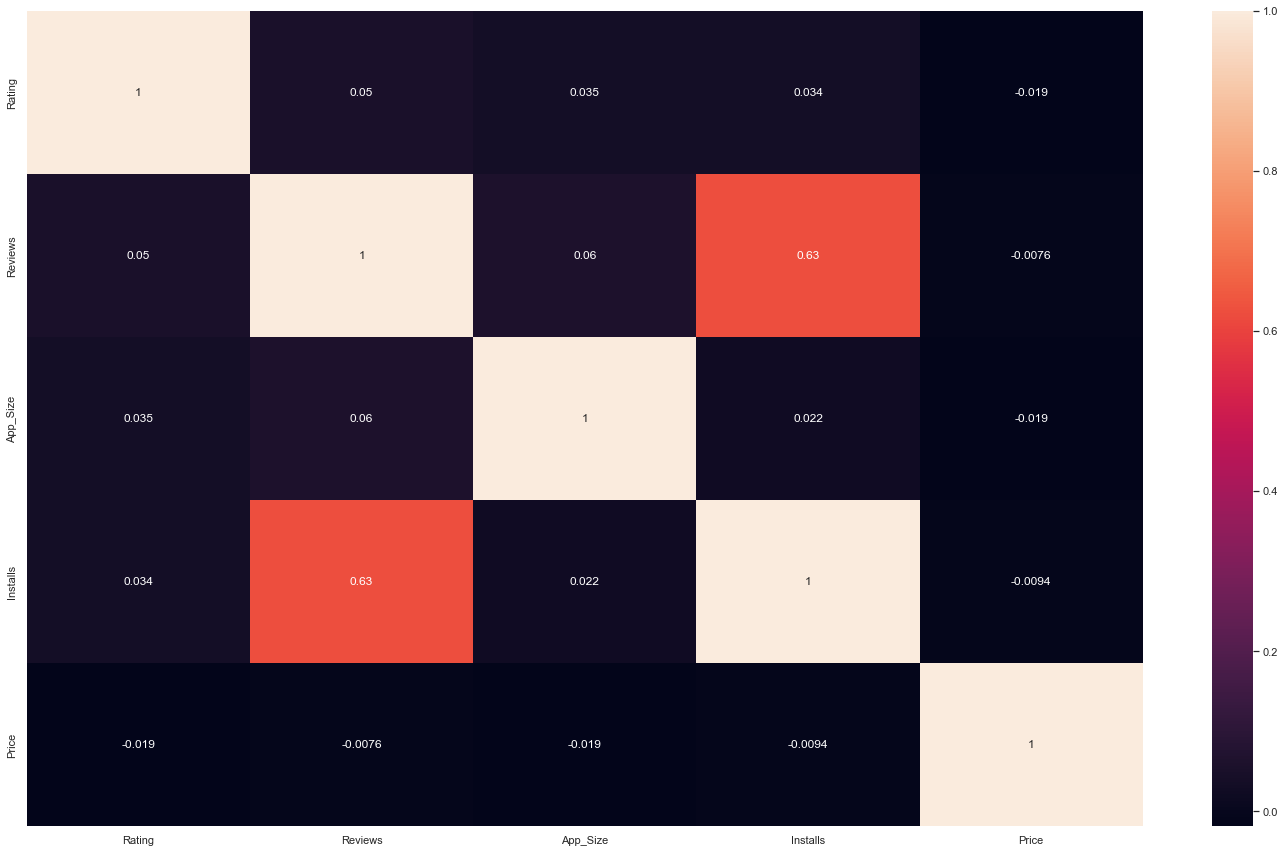

In [92]:
corrmat = df.corr()
p =sns.heatmap(corrmat, annot=True)